<a href="https://colab.research.google.com/github/Shukaria10/Potato_final_year_project/blob/main/potato_CNN_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow-gpu

     |████████████████████████████████| 394.3MB 41kB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!nvidia-smi

Tue May 11 14:48:08 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# **Import libraries**

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPool2D, BatchNormalization,Input,MaxPooling2D,GlobalMaxPooling2D,concatenate
from tensorflow.keras.layers import GlobalAveragePooling2D
#from keras.applications import vgg19
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
import tensorflow as tf

# **Data augmentation,Train,Test,Validation**

In [ ]:
from keras_preprocessing.image import ImageDataGenerator

data_gen= ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=360,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=.1,
    rescale=1/255,
    fill_mode='nearest',
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    validation_split=0.3)

In [ ]:
img_shape=300
batch_size=16
input_shape=(img_shape,img_shape,3)

In [ ]:
#load the training data
leaves_train_generator = data_gen.flow_from_directory(
    '/content/drive/MyDrive/final_year_project/dataset_splits/train',
    target_size=(img_shape,img_shape),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True)

Found 1205 images belonging to 3 classes.


In [ ]:
#load the training data
val_suffle=False
leaves_val_generator = data_gen.flow_from_directory(
    '/content/drive/MyDrive/final_year_project/dataset_splits/validation',
    target_size=(img_shape,img_shape),
    batch_size=16,
    class_mode='categorical',
    subset='validation',shuffle=val_suffle)#shuffle should be False in validation
    #https://stackoverflow.com/a/47439789/11170350

Found 96 images belonging to 3 classes.


In [ ]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

In [ ]:
leaves_train_generator.next()[0].shape,leaves_train_generator.next()[1].shape

((16, 300, 300, 3), (16, 3))

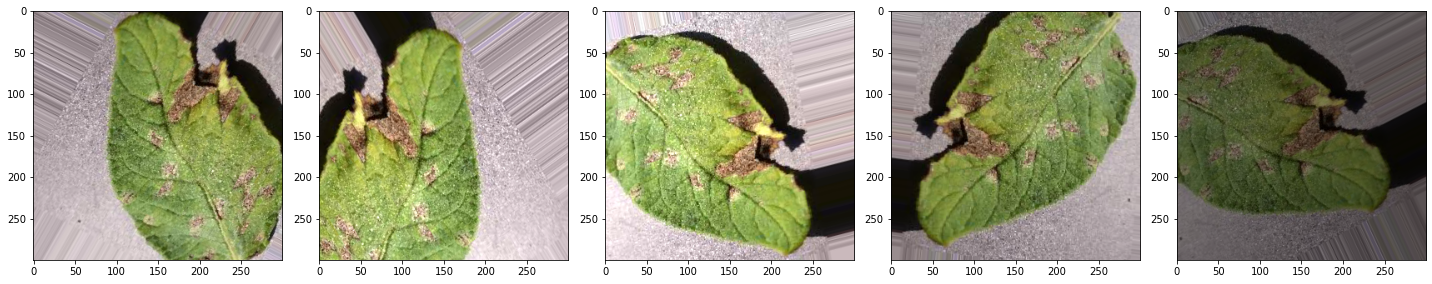

In [ ]:
images = [leaves_train_generator[0][0][0] for i in range(5)]
plotImages(images)

In [ ]:
leaves_val_generator.next()[0].shape,leaves_val_generator.next()[1].shape

((16, 300, 300, 3), (16, 3))

# **Model**

In [ ]:
model = Sequential()
model.add(Conv2D(32, (5, 5),input_shape=input_shape,activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Conv2D(32, (3, 3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))   
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(128,activation='relu'))          
model.add(Dense(3,activation='softmax'))
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 296, 296, 32)      2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 98, 98, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 96, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 33856)             0

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
trainable_count = np.sum([K.count_params(w) for w in model.trainable_weights])
non_trainable_count = np.sum([K.count_params(w) for w in model.non_trainable_weights])

print('Total params: {:,}'.format(trainable_count + non_trainable_count))
print('Trainable params: {:,}'.format(trainable_count))
print('Non-trainable params: {:,}'.format(non_trainable_count))

Total params: 17,431,011.0
Trainable params: 17,431,011
Non-trainable params: 0.0


In [ ]:
def custom_loss(y_true, y_pred):
    return tf.keras.losses.categorical_crossentropy(y_true, y_pred, label_smoothing=0.1)

# **Training Model**

In [ ]:
results = model.fit(leaves_train_generator,epochs=30,
                              steps_per_epoch=leaves_train_generator.n/batch_size,
                              validation_data=leaves_val_generator,
                             validation_steps=leaves_val_generator.n/batch_size
                    
                              )

Epoch 1/30
75/75 [==============================] - 741s 9s/step - loss: 1.2065 - accuracy: 0.4266 - val_loss: 0.8850 - val_accuracy: 0.6562
Epoch 2/30
75/75 [==============================] - 36s 475ms/step - loss: 0.8610 - accuracy: 0.5494 - val_loss: 0.8652 - val_accuracy: 0.5729
Epoch 3/30
75/75 [==============================] - 36s 474ms/step - loss: 0.8145 - accuracy: 0.6634 - val_loss: 0.7336 - val_accuracy: 0.7604
Epoch 4/30
75/75 [==============================] - 36s 474ms/step - loss: 0.7667 - accuracy: 0.6976 - val_loss: 0.7032 - val_accuracy: 0.7396
Epoch 5/30
75/75 [==============================] - 35s 471ms/step - loss: 0.5993 - accuracy: 0.7819 - val_loss: 0.4827 - val_accuracy: 0.8229
Epoch 6/30
75/75 [==============================] - 35s 469ms/step - loss: 0.5113 - accuracy: 0.7911 - val_loss: 0.7258 - val_accuracy: 0.6562
Epoch 7/30
75/75 [==============================] - 35s 470ms/step - loss: 0.7395 - accuracy: 0.6932 - val_loss: 0.4098 - val_accuracy: 0.8542
E

# **Plot**

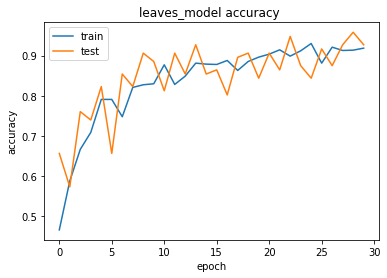

In [ ]:
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('leaves_model accuracy ')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

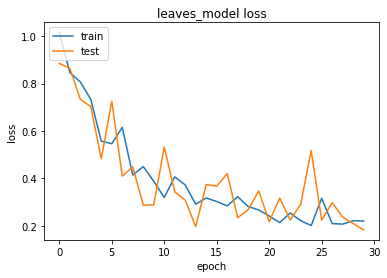

In [ ]:
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('leaves_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## **Evaluate & Performance Model**

In [ ]:
model.evaluate(leaves_val_generator,steps=leaves_val_generator.n//batch_size)

6/6 [==============================] - 3s 416ms/step - loss: 0.1535 - accuracy: 0.9271


[0.15348351001739502, 0.9270833134651184]

In [ ]:
leaves_val_generator.reset()
model.evaluate(leaves_val_generator,steps=leaves_val_generator.n//batch_size)

6/6 [==============================] - 3s 414ms/step - loss: 0.1873 - accuracy: 0.9271


[0.18727928400039673, 0.9270833134651184]

In [ ]:
leaves_val_generator.reset()
y_pred=model.predict(leaves_val_generator,steps=leaves_val_generator.n/batch_size,verbose=1)

6/6 [==============================] - 3s 427ms/step


In [ ]:
leaves_val_generator.reset()
y_pred=model.predict(leaves_val_generator,steps=leaves_val_generator.n/batch_size,verbose=1)

6/6 [==============================] - 3s 419ms/step


In [ ]:
if val_suffle==True:
  per = np.random.permutation(leaves_val_generator.n)
  leaves_val_generator.index_array = per
  y_true = leaves_val_generator.classes[per]
else: 
  y_true = leaves_val_generator.classes

In [ ]:
y_pred=np.argmax(y_pred, axis=1)

In [ ]:
y_pred.shape,y_true.shape

((96,), (96,))

# **Precision,recall,f1 score,model accuracy report**

In [ ]:
from sklearn.metrics import classification_report,accuracy_score,f1_score,precision_score,recall_score
print(accuracy_score(y_true,y_pred))
print(precision_score(y_true, y_pred,average='macro'))
print(recall_score(y_true, y_pred,average='macro'))
print(f1_score(y_true,y_pred,average='macro'))



0.9375
0.8866925064599483
0.9555555555555556
0.9150072150072149


In [ ]:
class_label=list(leaves_train_generator.class_indices.keys())
print(classification_report(y_true, y_pred,target_names=class_label))

                       precision    recall  f1-score   support

Potato___Early_blight       0.98      0.93      0.95        45
 Potato___Late_blight       0.93      0.93      0.93        45
     Potato___healthy       0.75      1.00      0.86         6

             accuracy                           0.94        96
            macro avg       0.89      0.96      0.92        96
         weighted avg       0.94      0.94      0.94        96



# **Confusion matrix**

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


#Defining function for confusion matrix plot
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):

    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    #Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#print(cm)

    fig, ax = plt.subplots(figsize=(7,7))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')


    #Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

np.set_printoptions(precision=2)

Confusion matrix, without normalization


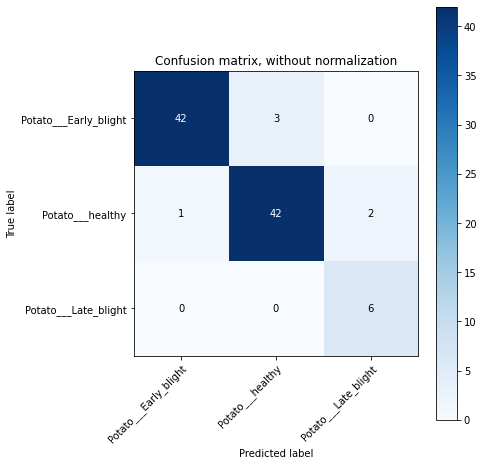

In [ ]:
#Plotting the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred)

#Defining the class labels
class_names=['Potato___Early_blight', 'Potato___healthy', 'Potato___Late_blight']

# Plotting non-normalized confusion matrix
plot_confusion_matrix(y_true, y_pred, classes = class_names, title='Confusion matrix, without normalization')

Normalized confusion matrix


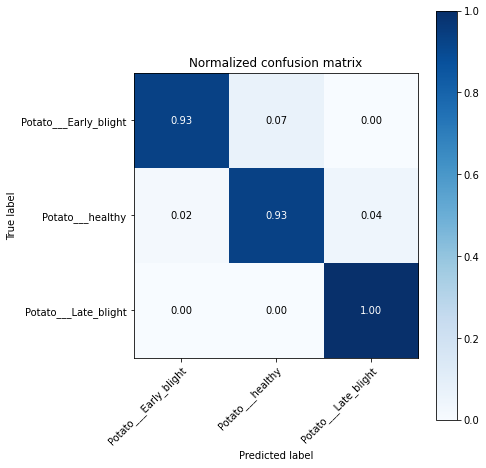

In [ ]:
#Plotting normalized confusion matrix
plot_confusion_matrix(y_true, y_pred, classes = class_names, normalize = True, title = 'Normalized confusion matrix')

# **ROC, AUC_Score ,ROC_AUC Curve for each class**

In [ ]:
y_prob=model.predict_proba(leaves_val_generator,verbose=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


6/6 [==============================] - 3s 426ms/step


In [ ]:
y_prob

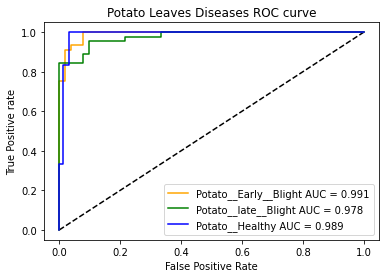

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr = {}
tpr = {}
thresh ={}
roc_auc={}

n_class = 3

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_true, y_prob[:,i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])
plt.plot([0, 1], [0, 1], 'k--')      
plt.plot(fpr[0], tpr[0], color='orange',label='Potato__Early__Blight AUC = %0.3f' % roc_auc[0])
plt.plot(fpr[1], tpr[1], color='green',label='Potato__late__Blight AUC = %0.3f' % roc_auc[1])
plt.plot(fpr[2], tpr[2], color='blue',label='Potato__Healthy AUC = %0.3f' % roc_auc[2])

plt.title('Potato Leaves Diseases ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
auc_cnn = roc_auc_score(y_true, y_prob,multi_class="ovr",
                                     average="weighted")
print(auc_cnn)

0.9845996732026144
